### Imports

In [1]:
import struct

import numpy as np
import matplotlib.pyplot as plt

from scipy.constants import pi, c
from scipy.fft import fft, ifft, fftshift, ifftshift, ifft2, fft2

from decoding import get_header_dict, packet_generator_from_file, packet_generator, build_data_word_dict, index_decoder, annotation_decoder
from packet import Packet
from utils import create_bit_string, find_packet_of_type, time_packet_generation
from structs import F_REF

### Plotting Functions

In [2]:
def plot_signal(signal, title=""):
    fig = plt.figure()
    fig.set_size_inches(12, 2)
    plt.plot(signal)
    plt.title(title)

def plot_signal_components(signal, start_time, end_time, scale=(None, None), fft_size=128, sample_rate=3*1e+8, title="", size=(6, 12)):
    t = np.linspace(start_time, end_time, signal.shape[0])
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(size[1], size[0]))
    ax1.plot(t, signal.imag, linewidth=0.75, label='Imaginary Part', color="red")
    ax1.plot(t, signal.real, linewidth=0.75, label='Real Part', color="darkblue")
    ax1.set_title(title)
    ax1.set_xlabel("Time (us)")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="lower right")
    ax1.grid(True)
    ax1.set_xlim([t[0], t[-1]])
    ax2.plot(t, np.unwrap(np.angle(signal)), linewidth=0.75, color="red")
    ax2.set_xlabel("Time (us)")
    ax2.set_ylabel("Phase")
    ax2.grid(True)
    ax2.set_xlim([t[0], t[-1]])
    if scale is not None:
        ax3.specgram(signal, NFFT=fft_size, Fs=sample_rate, noverlap=fft_size-1, cmap='seismic', vmin=scale[0], vmax=scale[1])
    else:
        ax3.specgram(signal, NFFT=fft_size, Fs=sample_rate, noverlap=fft_size-1, cmap='seismic')
    ax3.set_xlabel("Time (us)")
    ax3.set_ylabel("Frequency")
    plt.tight_layout()
    plt.subplots_adjust(top=0.75)
    plt.show()

def norm_log(signal, weight=20):
    norm = np.abs(signal) / np.max(np.abs(signal))
    return weight * np.log10(norm)

### Saving Function

In [3]:
def save_to_cf32(data: np.ndarray, filename: str):
    if not np.iscomplexobj(data):
        raise ValueError("Input data must be a complex numpy array.")
    interleaved_data = np.empty(2 * len(data), dtype=np.float32)
    interleaved_data[0::2] = data.real.astype(np.float32)
    interleaved_data[1::2] = data.imag.astype(np.float32)
    interleaved_data.tofile(filename)

### Processing Functions

In [4]:
range_decimation_list = [
    112.6041667, 100.0925926, 0.000000000, 83.41049387,
    66.72839509, 56.30208336, 50.04629632, 25.02314816,
    64.34523813, 46.91840280, 17.32371796, 54.59595962
]

def get_replica_chirp(packet):
    secondary_header = packet.get_secondary_header()
    range_decimation = secondary_header['range_decimation']
    txpsf = secondary_header['tx_pulse_start_frequency']
    txprr = secondary_header['tx_ramp_rate']
    txpl  = secondary_header['pulse_length']
    phi_1 = txpsf
    phi_2 = txprr / 2
    fs = int(np.floor(range_decimation_list[range_decimation] * txpl))
    t = np.linspace(0.0, txpl, fs)
    chirp = (1 / fs) * np.exp(2 * pi * 1j * (phi_1 * t + phi_2 * (t**2)))
    return chirp

def get_reference_function(replica, ref_samples):
    rep_samples = replica.shape[0]
    ref_func = np.pad(replica, (0, ref_samples - rep_samples))
    window = np.hanning(ref_samples)
    reference = np.conj(ref_func) * window
    norm = np.abs(reference)
    energy = 0.0
    for i in range(ref_samples):
        energy += (norm[i] * norm[i])
    energy /= ref_samples
    for i in range(ref_samples):
        reference[i] = reference[i] / energy
    return np.asarray(reference)

def pulse_compression(chirp, replica):
    num_range_samples = chirp.shape[0]
    num_rep_samples = replica.shape[0]
    fft_pad_amount = int(2**np.ceil(np.log2(num_range_samples)) - num_range_samples)
    chirp_padded = np.pad(chirp, (0, fft_pad_amount))
    f_chirp = fft(chirp_padded)
    ref_func = get_reference_function(replica, num_range_samples + fft_pad_amount)
    f_ref_func = fft(ref_func)
    pulse_compressed = np.roll(ifft(f_chirp * f_ref_func), (fft_pad_amount-num_rep_samples))
    return pulse_compressed[fft_pad_amount-num_rep_samples:]

def get_nth_packet(filename, n):
    raw_data = open(filename, 'rb')
    PacketGenerator = packet_generator(raw_data)
    packet = None
    index = 0
    while index <= n:
        packet = next(PacketGenerator)
        index += 1
    return packet

### Get Signals

In [5]:
filename = '../../sentinel1_decode/data/sample/sample.dat'
packet = get_nth_packet(filename, 500)
signal = packet.get_complex_samples()[0]
replica = get_replica_chirp(packet)
reference_function = get_reference_function(replica, signal.shape[0])
pulse_compressed = pulse_compression(signal, replica)
cross_correlated = np.correlate(signal, replica, "full")

### Save Signals

In [8]:
# save_to_cf32(signal, 'signal.cf32')
# save_to_cf32(signals.flatten(), 'signals.cf32')
# save_to_cf32(references.flatten(), 'references.cf32')
# save_to_cf32(np.asarray(replicas).flatten(), 'replicas.cf32')
# save_to_cf32(replica, 'replica.cf32')
# save_to_cf32(reference_function, 'reference.cf32')
# save_to_cf32(pulse_compressed, 'pulse_compressed.cf32')
# save_to_cf32(cross_correlated, 'cross_correlated.cf32')

### Plot Signals

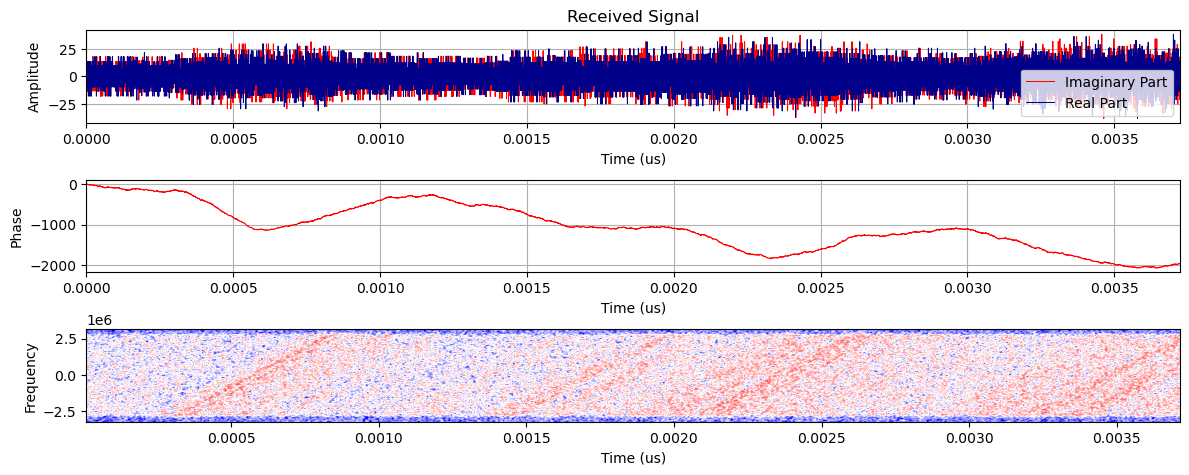

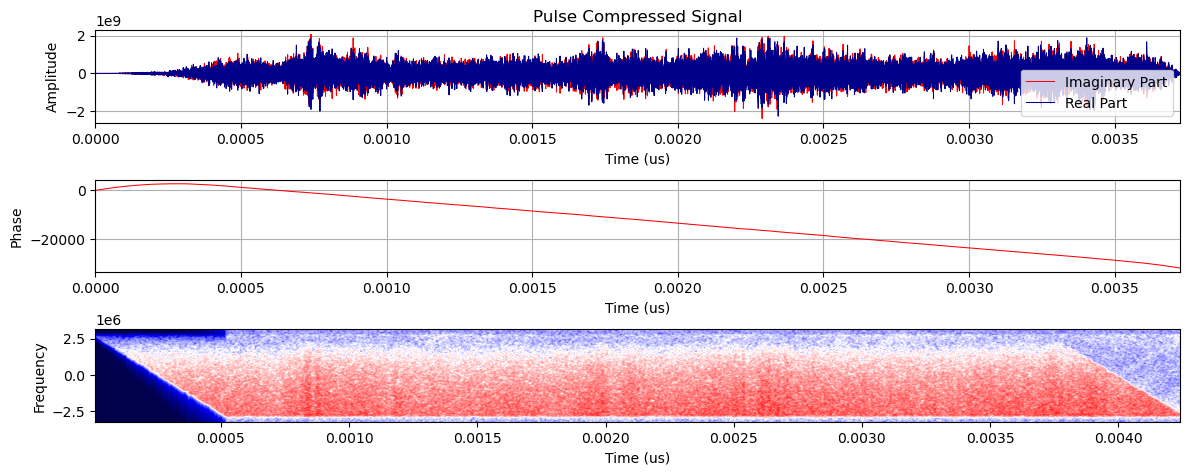

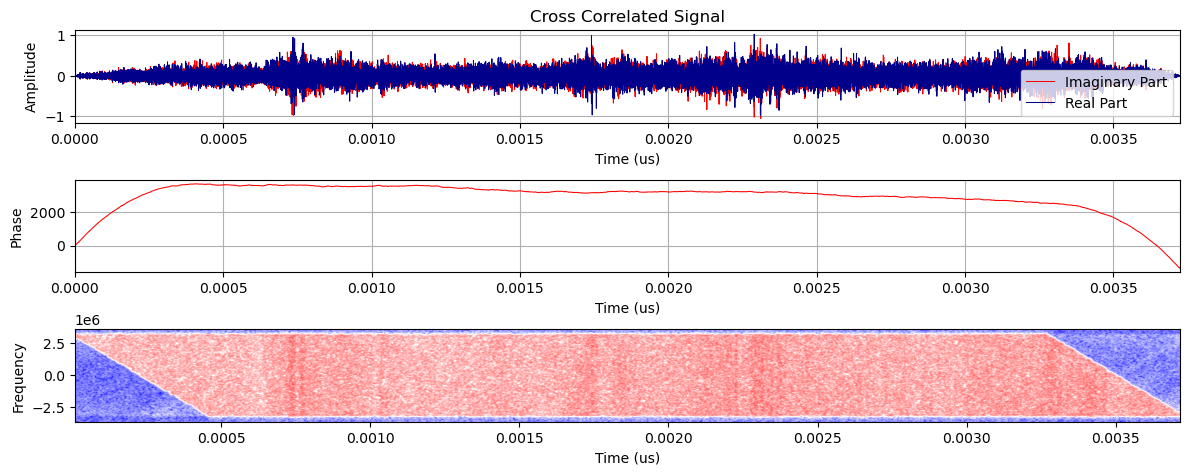

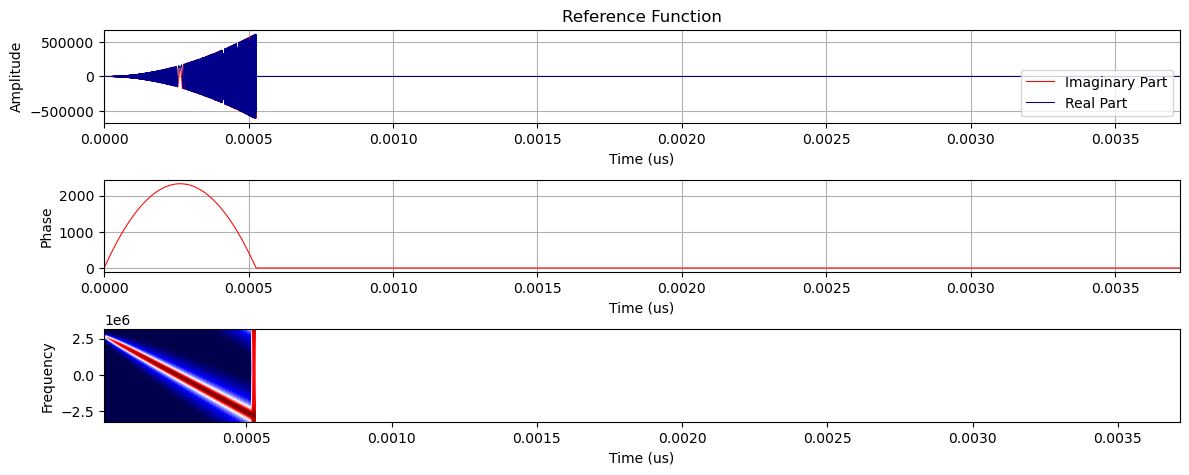

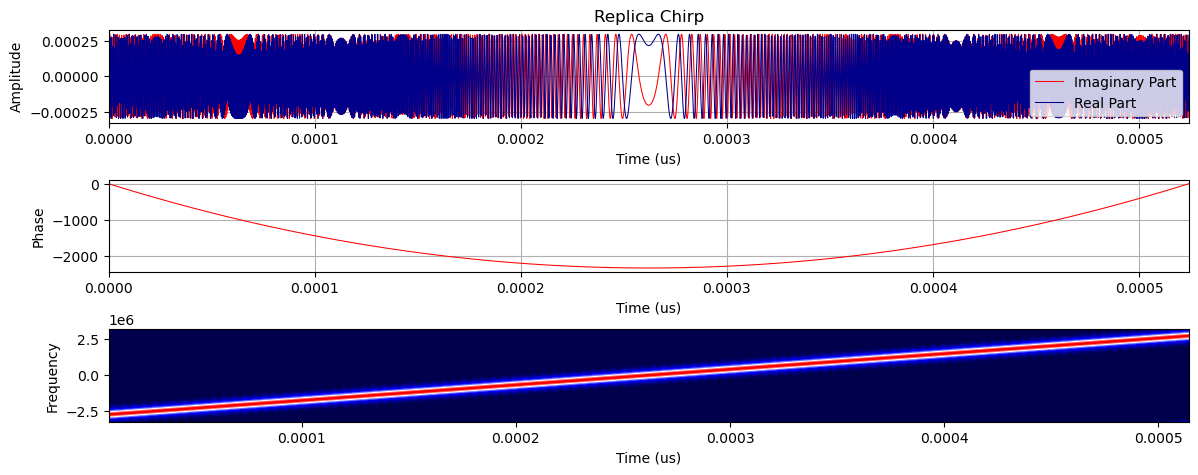

In [9]:
pop_out_plots = False
if pop_out_plots:
    %matplotlib qt
else:
    %matplotlib inline

packet_header = packet.get_secondary_header()
sampling_window_length = packet_header["swl"] * 10e-6
txpl = packet_header["pulse_length"]
pulse_length = txpl * 10e-6
range_decimation = packet_header["range_decimation"]
delta_t_suppressed = (320 / (8 * F_REF)) * 1e-6
start_time = packet_header["swst"] * 1e-6
pri = packet_header["pri"] * 1e-6
rank = packet_header["rank"]
delay = rank * pri + start_time + delta_t_suppressed
fft_size = 128
sample_rate = signal.shape[0] / sampling_window_length

plot_signal_components(signal, 0, sampling_window_length, scale=(-100, 0), fft_size=fft_size, sample_rate=sample_rate, title="Received Signal")
plot_signal_components(pulse_compressed, 0, sampling_window_length, scale=(-5, 175), fft_size=fft_size, sample_rate=sample_rate, title="Pulse Compressed Signal")
plot_signal_components(cross_correlated, 0, sampling_window_length, scale=(-200, 0), fft_size=fft_size, sample_rate=cross_correlated.shape[0]/sampling_window_length, title="Cross Correlated Signal")
plot_signal_components(reference_function, 0, sampling_window_length, scale=(-50, 50), fft_size=fft_size, sample_rate=sample_rate, title="Reference Function")
plot_signal_components(replica, 0, pulse_length, scale=(-200, -100), fft_size=fft_size, sample_rate=(replica.shape[0]/pulse_length), title="Replica Chirp")

### Time Delay and Range to Target

In [10]:
compressed_abs = np.abs(pulse_compressed)
t = np.linspace(delay, delay + sampling_window_length, signal.shape[0])
threshold = 1.5 * 1e9
for i in range(compressed_abs.shape[0]):
    val = compressed_abs[i]
    if val > threshold:
        print (f"Target Time Delay: {t[i]} seconds")
        print (f"Target Distance: {t[i]*c/2} meters")
        break
start_range = (delay * c) / 2
end_range = (delay + sampling_window_length) * c / 2
print (f"Window Start Range: {start_range} meters")
print (f"Window End Range: {end_range} meters")

Target Time Delay: 0.006128508299144581 seconds
Target Distance: 918640.2834369766 meters
Window Start Range: 800512.0886038558 meters
Window End Range: 1358768.3537742358 meters


### Working with a Burst

#### Retrieve Packets and Load Signals

In [11]:
def get_packets_in_swath(data, swath_num):
    PacketGenerator = packet_generator(data)
    swath_packets = []
    packet_index = 0
    while (data):
        try:
            packet = next(PacketGenerator)
            if packet.data_format() == 'D':
                if packet.get_secondary_header()['swath_number'] == swath_num:
                    swath_packets.append((packet, packet_index))
            packet_index += 1
        except ValueError as ve:
            break
    return swath_packets

def get_packets_in_bursts(swath_packets):
    bursts = []
    burst_packets = []
    previous_az = 0
    index = 0
    for packet, packet_index in swath_packets:
        az = packet.get_secondary_header()['azimuth_beam_address']
        if index == 0:
            previous_az = az
        if az != previous_az and az != previous_az + 1:
            bursts.append(burst_packets)
            burst_packets = []
        burst_packets.append((packet, packet_index))
        previous_az = az
        if index == len(swath_packets) - 1:
            bursts.append(burst_packets)
        index += 1
    return bursts

def get_packets_in_burst(swath_packets, burst_num):
    bursts = get_packets_in_bursts(swath_packets)
    return bursts[burst_num]

def plot_signals(signals, title="", xlabel="", ylabel="", aspect="auto"):
    fig = plt.figure()
    fig.set_size_inches(12, 3)
    plt.imshow(signals, cmap='jet', aspect=aspect, origin="lower")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

In [12]:
data = open(filename, 'rb')
swath_packets = get_packets_in_swath(data, 10)
burst_packet_pairs = get_packets_in_burst(swath_packets, 10)
burst_packets = [packet for packet, _ in burst_packet_pairs]
packet_indecies = [index for _, index in burst_packet_pairs]
signals = np.load("burst_iw1_10.npy")

### Range Compression

#### Range Compression with Pulse Compression

In [13]:
def get_replica_chirps(packets):
    replica_chirps = []
    for packet in packets:
        secondary_header = packet.get_secondary_header()
        range_decimation = secondary_header['range_decimation']
        txpsf = secondary_header['tx_pulse_start_frequency']
        txprr = secondary_header['tx_ramp_rate']
        txpl  = secondary_header['pulse_length']
        phi_1 = txpsf - (txprr * (-txpl/2))
        phi_2 = txprr / 2
        fs = int(np.floor(range_decimation_list[range_decimation] * txpl))
        t = np.linspace(-txpl*0.5, txpl*0.5, fs)
        chirp = (1 / fs) * np.exp(2 * pi * 1j * (phi_1 * t + phi_2 * (t**2)))
        replica_chirps.append(chirp)
    return np.asarray(replica_chirps)

def range_compress_burst(signals, replica_chirps):
    num_packets = signals.shape[0]
    range_compressed_signals = []
    for i in range(num_packets):
        range_compressed_signals.append(pulse_compression(signals[i], replica_chirps[i]))
    return np.asarray(range_compressed_signals)

In [14]:
replica_chirps = get_replica_chirps(burst_packets)
range_compressed_burst = range_compress_burst(signals, replica_chirps)
range_compressed_burst_norm = np.abs(range_compressed_burst) / np.max(np.abs(range_compressed_burst))

#### Range Compression with Cross Correlation

In [15]:
def cross_correlate_signals(signals, replica_chirps):
    cross_correlated_signals = []
    for i in range(signals.shape[0]):
        cross_correlated_signals.append(np.correlate(signals[i], replica_chirps[i], "full"))
    return np.asarray(cross_correlated_signals)

In [16]:
cross_correlated_burst = cross_correlate_signals(signals, replica_chirps)
cross_correlated_burst_norm = np.abs(cross_correlated_burst) / np.max(np.abs(cross_correlated_burst))

#### Plotting

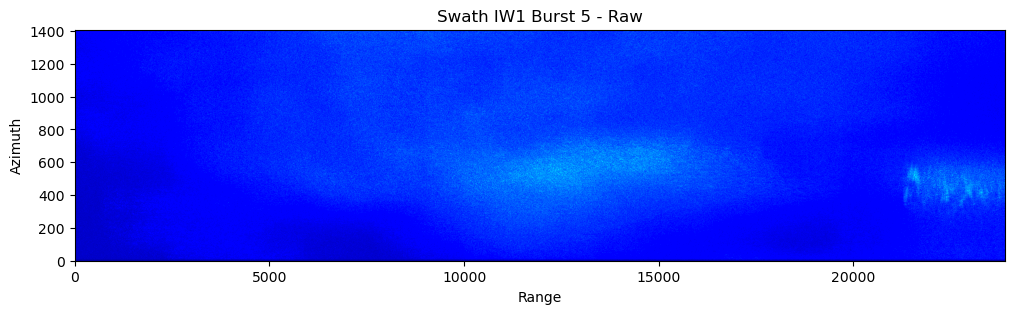

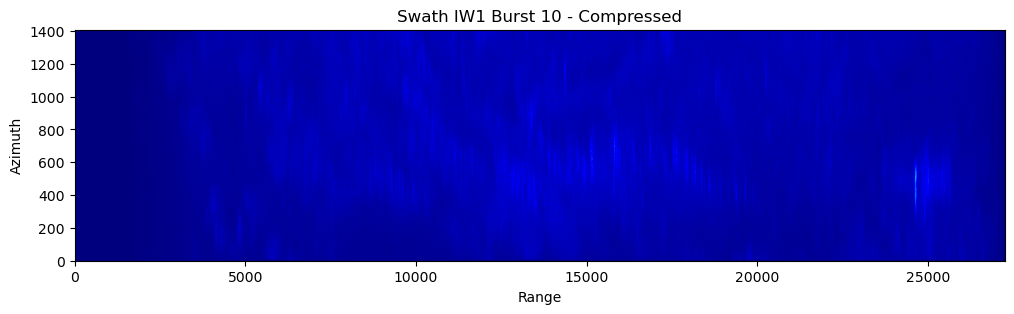

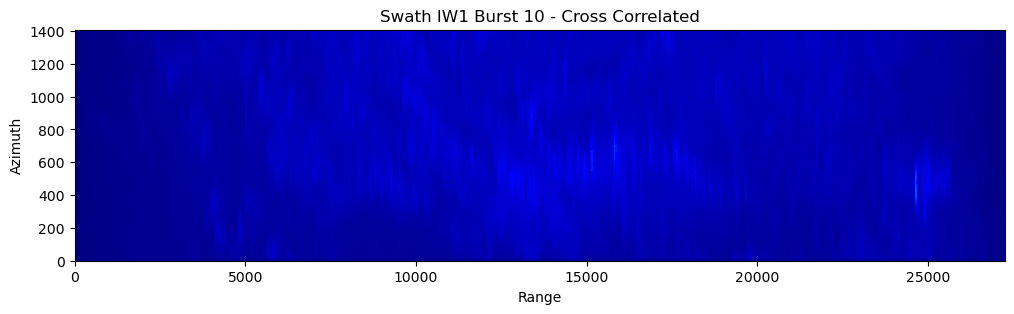

In [17]:
plot_signals(np.abs(signals) / np.max(np.abs(signals)), title="Swath IW1 Burst 5 - Raw", xlabel="Range", ylabel="Azimuth")
plot_signals(range_compressed_burst_norm, title="Swath IW1 Burst 10 - Compressed", xlabel="Range", ylabel="Azimuth")
plot_signals(cross_correlated_burst_norm, title="Swath IW1 Burst 10 - Cross Correlated", xlabel="Range", ylabel="Azimuth")

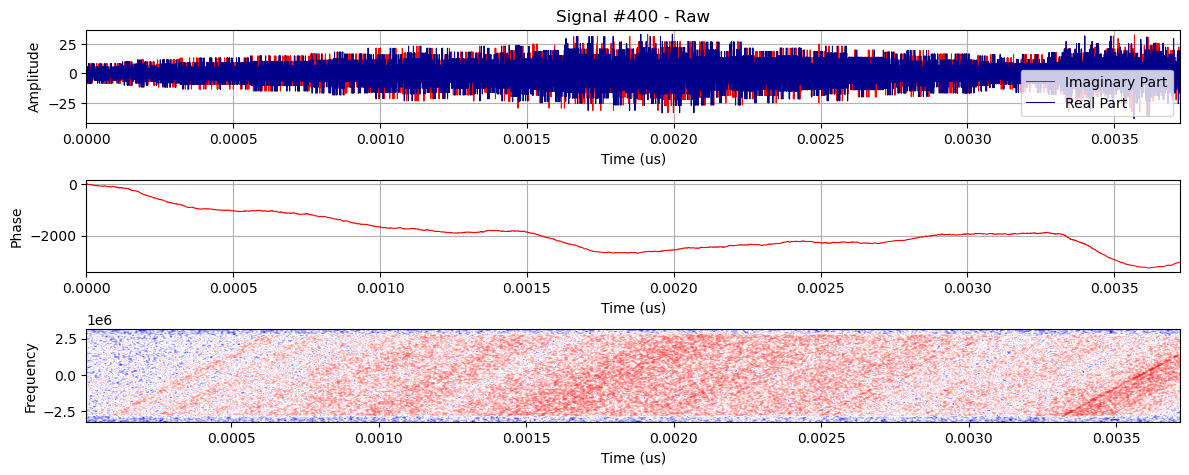

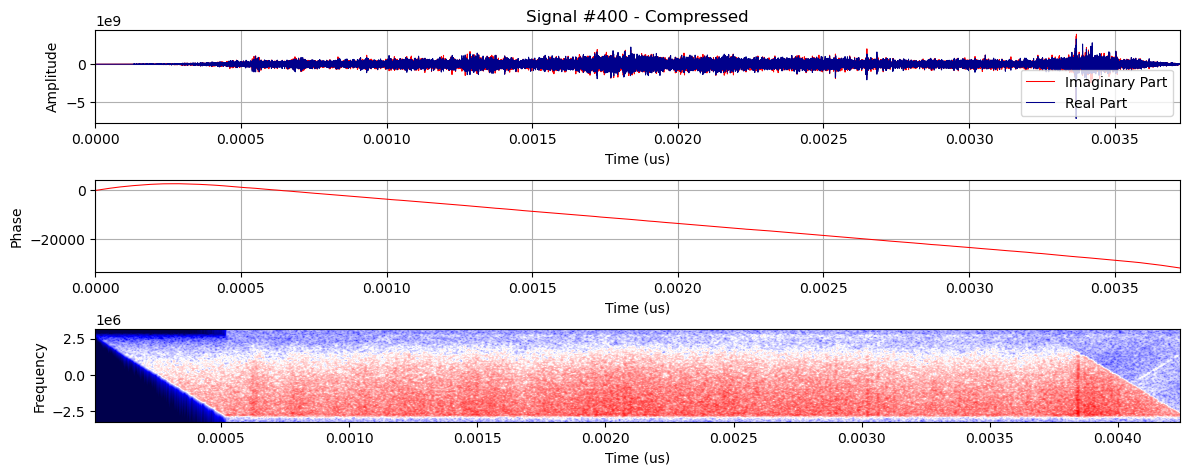

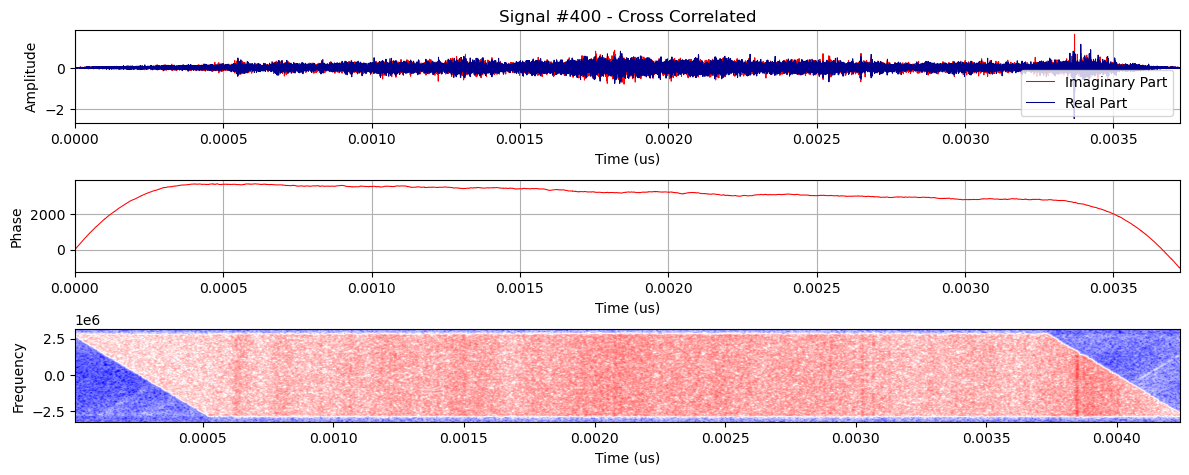

In [18]:
plot_signal_components(signals[400], 0, sampling_window_length, scale=(-110, 0), fft_size=fft_size, sample_rate=sample_rate, title="Signal #400 - Raw")
plot_signal_components(range_compressed_burst[400], 0, sampling_window_length, scale=(-5, 175), fft_size=fft_size, sample_rate=sample_rate, title="Signal #400 - Compressed")
plot_signal_components(cross_correlated_burst[400], 0, sampling_window_length, scale=(-200, 0), fft_size=fft_size, sample_rate=sample_rate, title="Signal #400 - Cross Correlated")

### Range Doppler Space

In [19]:
range_doppler_compressed_burst = fft(range_compressed_burst, axis=0)
range_doppler_correlated_burst = fft(cross_correlated_burst, axis=0)

range_doppler_compressed_burst_norm = np.abs(range_doppler_compressed_burst) / np.max(np.abs(range_doppler_compressed_burst))
range_doppler_correlated_burst_norm = np.abs(range_doppler_correlated_burst) / np.max(np.abs(range_doppler_correlated_burst))

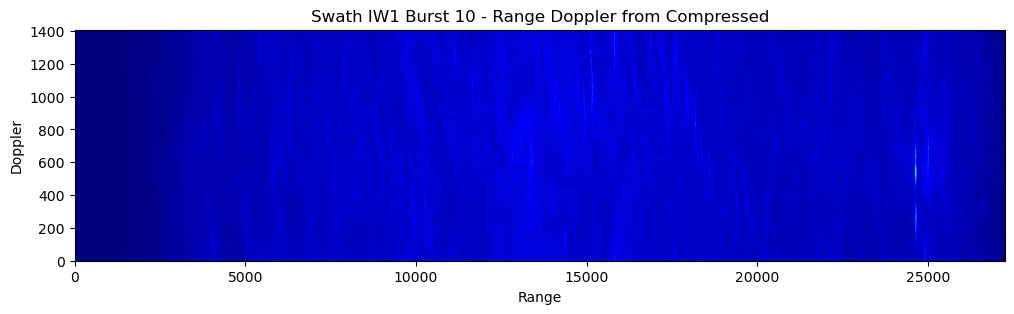

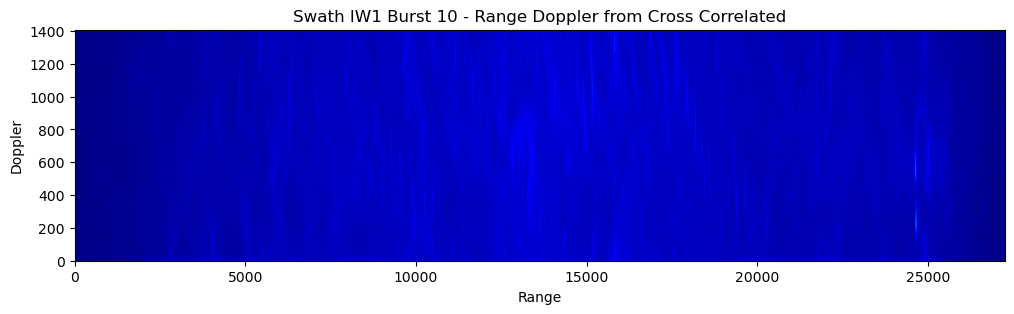

In [20]:
plot_signals(range_doppler_compressed_burst_norm, title="Swath IW1 Burst 10 - Range Doppler from Compressed", xlabel="Range", ylabel="Doppler")
plot_signals(range_doppler_correlated_burst_norm, title="Swath IW1 Burst 10 - Range Doppler from Cross Correlated", xlabel="Range", ylabel="Doppler")

In [21]:
ra_azimuth_signal_compressed = range_compressed_burst[:, 10000]
ra_azimuth_signal_correlated = cross_correlated_burst[:, 10000]
rd_azimuth_signal_compressed = range_doppler_compressed_burst[:, 10000]
rd_azimuth_signal_correlated = range_doppler_correlated_burst[:, 10000]

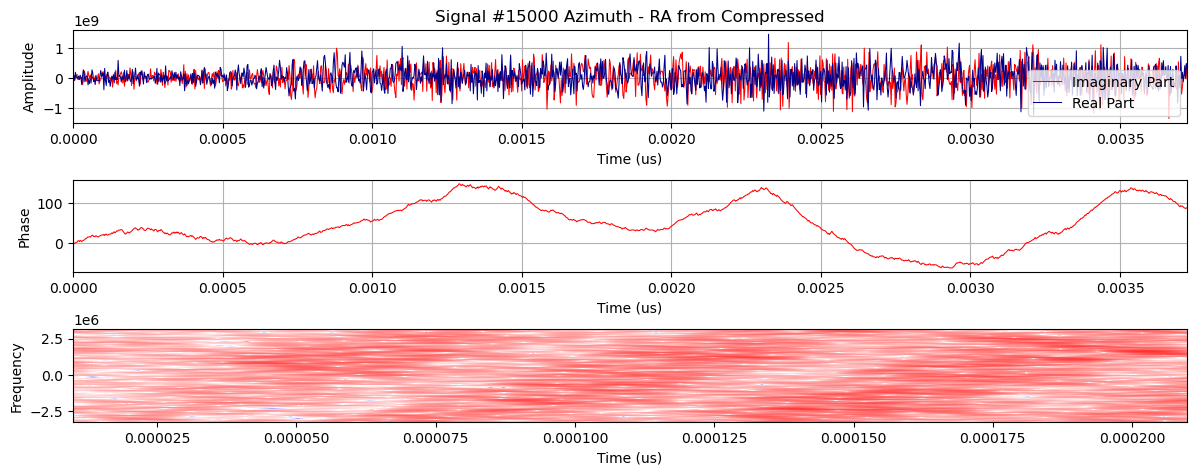

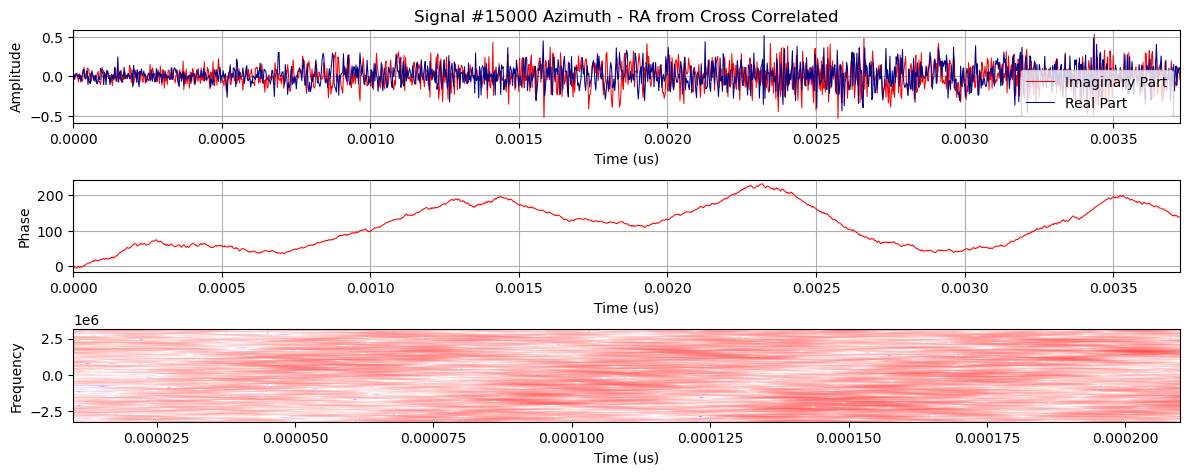

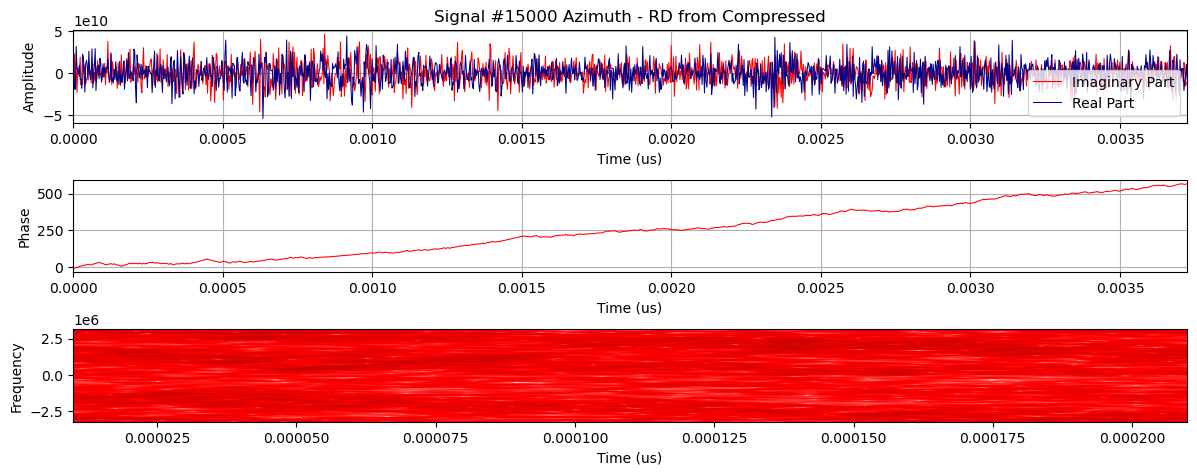

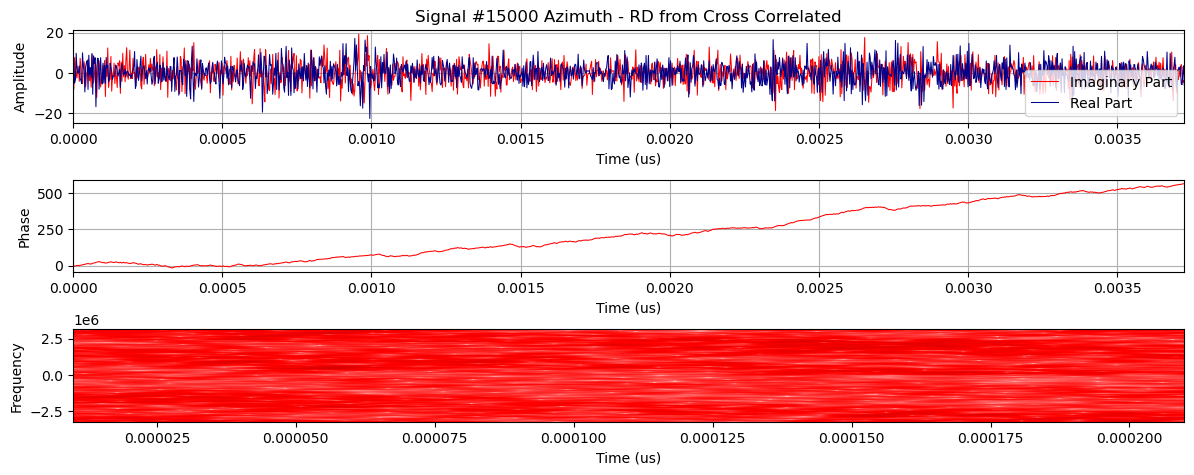

In [22]:
plot_signal_components(ra_azimuth_signal_compressed, 0, sampling_window_length, scale=(-5, 175), fft_size=fft_size, sample_rate=sample_rate, title="Signal #15000 Azimuth - RA from Compressed")
plot_signal_components(ra_azimuth_signal_correlated, 0, sampling_window_length, scale=(-200, 0), fft_size=fft_size, sample_rate=sample_rate, title="Signal #15000 Azimuth - RA from Cross Correlated")
plot_signal_components(rd_azimuth_signal_compressed, 0, sampling_window_length, scale=(-5, 175), fft_size=fft_size, sample_rate=sample_rate, title="Signal #15000 Azimuth - RD from Compressed")
plot_signal_components(rd_azimuth_signal_correlated, 0, sampling_window_length, scale=(-200, 0), fft_size=fft_size, sample_rate=sample_rate, title="Signal #15000 Azimuth - RD from Cross Correlated")

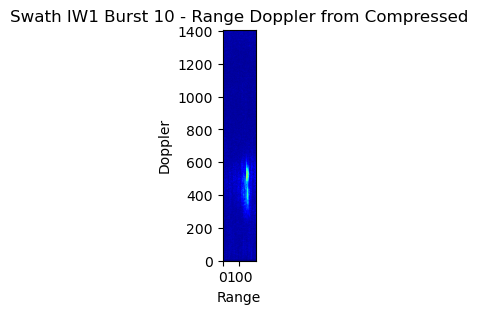

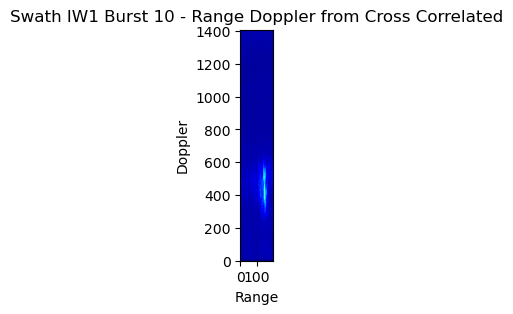

In [23]:
plot_signals(range_compressed_burst_norm[:, 24500:24700], title="Swath IW1 Burst 10 - Range Doppler from Compressed", xlabel="Range", ylabel="Doppler",  aspect="equal")
plot_signals(cross_correlated_burst_norm[:, 24500:24700], title="Swath IW1 Burst 10 - Range Doppler from Cross Correlated", xlabel="Range", ylabel="Doppler", aspect="equal")

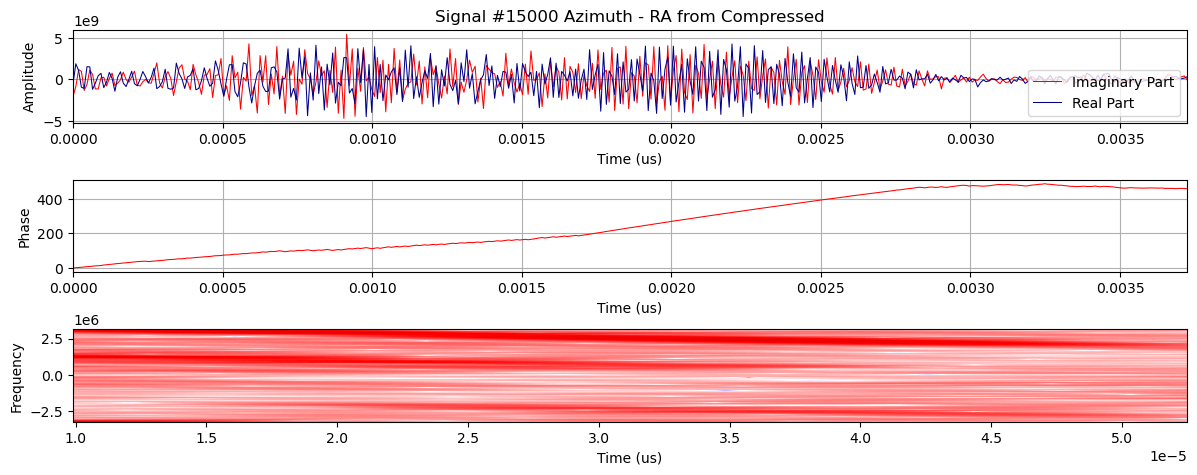

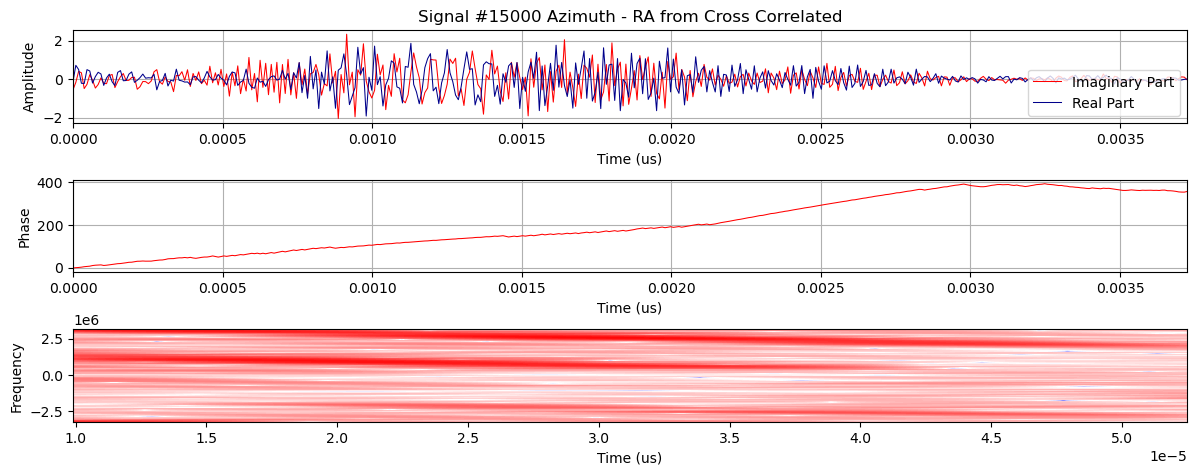

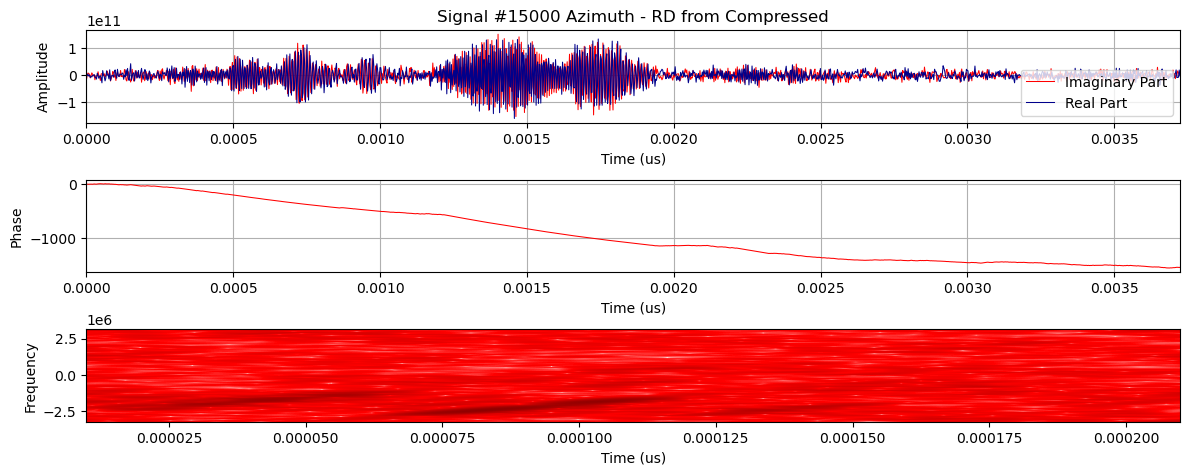

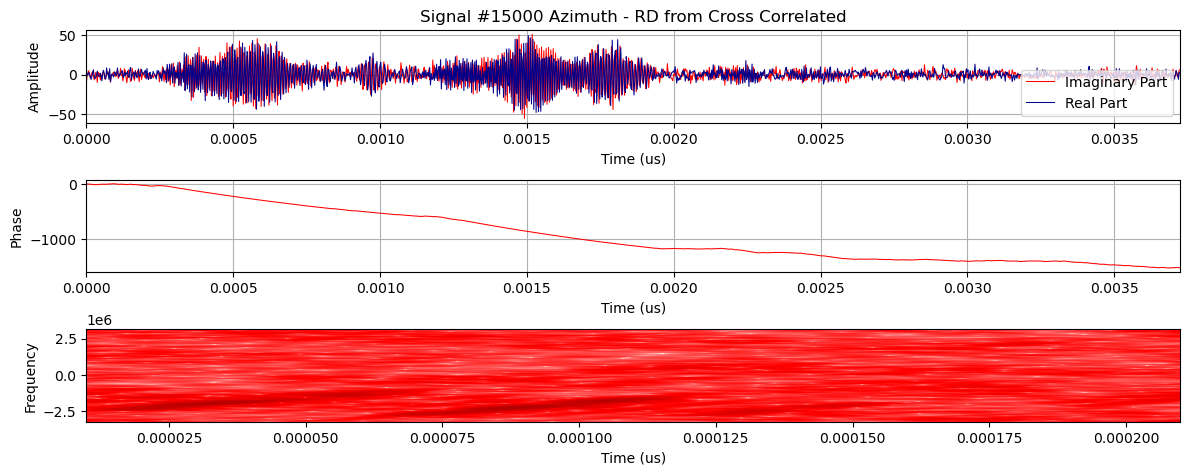

In [24]:
ra_azimuth_signal_compressed = range_compressed_burst[300:700, 24650]
ra_azimuth_signal_correlated = cross_correlated_burst[300:700, 24650]
rd_azimuth_signal_compressed = range_doppler_compressed_burst[:, 24650]
rd_azimuth_signal_correlated = range_doppler_correlated_burst[:, 24650]
plot_signal_components(ra_azimuth_signal_compressed, 0, sampling_window_length, scale=(-5, 175), fft_size=fft_size, sample_rate=sample_rate, title="Signal #15000 Azimuth - RA from Compressed")
plot_signal_components(ra_azimuth_signal_correlated, 0, sampling_window_length, scale=(-200, 0), fft_size=fft_size, sample_rate=sample_rate, title="Signal #15000 Azimuth - RA from Cross Correlated")
plot_signal_components(rd_azimuth_signal_compressed, 0, sampling_window_length, scale=(-5, 175), fft_size=fft_size, sample_rate=sample_rate, title="Signal #15000 Azimuth - RD from Compressed")
plot_signal_components(rd_azimuth_signal_correlated, 0, sampling_window_length, scale=(-200, 0), fft_size=fft_size, sample_rate=sample_rate, title="Signal #15000 Azimuth - RD from Cross Correlated")